# Task
**Create a chat bot**

In [ ]:
from google.colab import files                              # модуль для загрузки файлов в colab
import numpy as np                                          # библиотека для работы с массивами данных

from tensorflow.keras.models import Model, load_model       # из кераса подгружаем абстрактный класс базовой модели, метод загрузки предобученной модели
from tensorflow.keras.layers import Dense, Embedding, LSTM, Input # из кераса загружаем необходимые слои для нейросети
from tensorflow.keras.optimizers import RMSprop, Adadelta   # из кераса загружаем выбранный оптимизатор
from tensorflow.keras.preprocessing.sequence import pad_sequences # загружаем метод ограничения последовательности заданной длиной
from tensorflow.keras.preprocessing.text import Tokenizer   # загружаем токенизатор кераса для обработки текста
from tensorflow.keras import utils                          # загружаем утилиты кераса для one hot кодировки
from tensorflow.keras.utils import plot_model               # удобный график для визуализации архитектуры модели
from tensorflow.keras.callbacks import ModelCheckpoint
from keras import backend as K 
from numba import cuda

import yaml                                                 # импортируем модуль для удобной работы с файлами

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Preprocessing

In [ ]:
from socket import close
corpus = open('/content/drive/MyDrive/Базы/Диалоги(рассказы)_censored.yml','r')
document = yaml.safe_load(corpus)
conversations = document['разговоры']
print('Кол-во пар :',len(conversations))
print('Sample :',conversations[10])
corpus.close()


Кол-во пар : 11893
Sample : ['Как мама?', 'Ничего.']


In [ ]:
# there is only one sample with 3 elements
for i in conversations:
  if len(i) > 2:
    print(i)

['Ну?', 'Не будем горячиться. Сядь.', 'Да.']


In [ ]:
######################
# Create questions and answers lists with TEGs for answers
######################

questions = list()                        # create empty list for questions
answers = list()                          # create empty list for answers

for con in conversations:                                   # for every question/answer element
  if len(con) > 2 :                                         # if elements contains more then two Strings
    questions.append(con[0])                                # question put in questions list
    replies = con[1:]                                       # another Strings put in answers list
    ans = ''                                                # create empty String for full answer
    for rep in replies:                                     # for each answer Strings
      ans += ' ' + rep                                      # separate them by ' '
    answers.append(ans)                                     # full answer put in answers list
  elif len(con)> 1:                                         # if elements contains two Strings (only one question and answer)
    questions.append(con[0])                                # the same operation
    answers.append(con[1])                                  # 

# Очищаем строки с неопределенным типом ответов
answersCleaned = list()                                     # create list for cleaned answers
for i in range(len(answers)):
  if type(answers[i]) == str:                               # if answer string has type string
    answersCleaned.append(answers[i])                       # if answer is string then put it in Cl
  else:
    questions.pop(i)                                        # 

# create TEGs for answers
answers = list()
for i in range(len(answersCleaned)):
  answers.append( '<START> ' + answersCleaned[i] + ' <END>' )

# show new data
print('Вопрос : {}'.format(questions[200]))
print('Ответ : {}'.format(answers[200]))

Вопрос : Около сотни...
Ответ : <START> Точнее! <END>


In [ ]:
######################
# Create the index dictionary
######################
max_count_words = 7000
tokenizer = Tokenizer(max_count_words,'!"#$%&()*+,-–—./…:;<=>?@[\\]^_`{|}~«»\t\n\xa0\ufeff',oov_token= 'unknown', lower=True,)
tokenizer.fit_on_texts(questions + answers)                   # train tokenizer
vocabularyItems = list(tokenizer.word_index.items())
vocabularySize = len(vocabularyItems) + 1

print('Sample part of dict :',vocabularyItems[:20])
print('Size of Dict :' ,vocabularySize)

Sample part of dict : [('unknown', 1), ('start', 2), ('end', 3), ('что', 4), ('не', 5), ('я', 6), ('а', 7), ('ты', 8), ('это', 9), ('да', 10), ('в', 11), ('нет', 12), ('как', 13), ('и', 14), ('вы', 15), ('ну', 16), ('с', 17), ('на', 18), ('же', 19), ('так', 20)]
Size of Dict : 15093


In [ ]:
######################
# make x_train for encoder
######################
tokenizedQuestions = tokenizer.texts_to_sequences(questions)                                  # text -> indexes
maxLenQuestions = max([len(x) for x in tokenizedQuestions])                                   # find the max len of Question

paddedQuestions = pad_sequences(tokenizedQuestions, maxlen=maxLenQuestions, padding='post')   # fill the rest by zeroes

encoderForInput = paddedQuestions                                                             # it is our train_x for encoder

print('Пример оригинального вопроса на вход : {}'.format(questions[90]))                      # 
print('Пример кодированного вопроса на вход : {}'.format(encoderForInput[90])) 
print('Размеры закодированного массива вопросов на вход : {}'.format(encoderForInput.shape)) 
print('Установленная длина вопросов на вход : {}'.format(maxLenQuestions)) 

Пример оригинального вопроса на вход : Доклад твой, Иван Семенович?
Пример кодированного вопроса на вход : [5700  167  343 2143    0    0    0    0    0    0    0]
Размеры закодированного массива вопросов на вход : (11888, 11)
Установленная длина вопросов на вход : 11


In [ ]:
######################
# make x_train for decoder
######################
tokenizedAnswers = tokenizer.texts_to_sequences(answers) 
maxLenAnswers = max([len(x) for x in tokenizedAnswers]) 

paddedAnswers = pad_sequences(tokenizedAnswers, maxlen=maxLenAnswers, padding='post')


decoderForInput = paddedAnswers                                                         # it is our train_x for decoder
print('Пример оригинального ответа на вход: {}'.format(answers[90])) 
print('Пример раскодированного ответа на вход : {}'.format(decoderForInput[90])) 
print('Размеры раскодированного массива ответов на вход : {}'.format(decoderForInput.shape)) 
print('Установленная длина ответов на вход : {}'.format(maxLenAnswers)) 

Пример оригинального ответа на вход: <START> Мой? Что - некому больше? <END>
Пример раскодированного ответа на вход : [   2  105    4 2103  125    3    0    0    0    0    0    0    0]
Размеры раскодированного массива ответов на вход : (11888, 13)
Установленная длина ответов на вход : 13


In [ ]:
######################
# make y_train for decoder
######################
tokenizedAnswers = tokenizer.texts_to_sequences(answers)                                      # text -> indexes
for i in range(len(tokenizedAnswers)):
  tokenizedAnswers[i] = tokenizedAnswers[i][1:]                                               # delete index of <START>

paddedAnswers = pad_sequences(tokenizedAnswers,maxlen=maxLenAnswers,padding='post')    # fill the rest by zeroes

oneHotAnswers = utils.to_categorical(paddedAnswers,max_count_words)                            # indexes -> OHE with vocabularySize
decoderForOutput = np.array(oneHotAnswers)                                                    # save y_train as numpy

In [ ]:
print('Пример раскодированного ответа на вход : {}'.format(decoderForInput[100][:21]))  
print('Пример раскодированного ответа на выход : {}'.format(decoderForOutput[100][4][:21])) 
print('Размеры раскодированного массива ответов на выход : {}'.format(decoderForOutput.shape))
print('Установленная длина вопросов на выход : {}'.format(maxLenAnswers)) 

Пример раскодированного ответа на вход : [  2 673  20  94   1   3   0   0   0   0   0   0   0]
Пример раскодированного ответа на выход : [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Размеры раскодированного массива ответов на выход : (11888, 13, 7000)
Установленная длина вопросов на выход : 13


In [ ]:
######################
# Создаем рабочую модель для вывода ответов на запросы пользователя
######################
def makeInferenceModels():
  # Определим модель кодера, на входе далее будут закодированные вопросы(encoderForInputs), на выходе состояния state_h, state_c
  encoderModel = Model(encoderInputs, encoderStates) 

  decoderStateInput_h = Input(shape=(200 ,)) # обозначим размерность для входного слоя с состоянием state_h
  decoderStateInput_c = Input(shape=(200 ,)) # обозначим размерность для входного слоя с состоянием state_c

  decoderStatesInputs = [decoderStateInput_h, decoderStateInput_c] # возьмем оба inputs вместе и запишем в decoderStatesInputs

  # Берём ответы, прошедшие через эмбединг, вместе с состояниями и подаём LSTM cлою
  decoderOutputs, state_h, state_c = decoderLSTM(decoderEmbedding, initial_state=decoderStatesInputs)
  decoderStates = [state_h, state_c] # LSTM даст нам новые состояния
  decoderOutputs = decoderDense(decoderOutputs) # и ответы, которые мы пропустим через полносвязный слой с софтмаксом

  # Определим модель декодера, на входе далее будут раскодированные ответы (decoderForInputs) и состояния
  # на выходе предсказываемый ответ и новые состояния
  decoderModel = Model([decoderInputs] + decoderStatesInputs, [decoderOutputs] + decoderStates)

  return encoderModel , decoderModel

######################
# Создадим функцию, которая преобразует вопрос пользователя в последовательность индексов 
######################
def strToTokens(sentence: str): # функция принимает строку на вход (предложение с вопросом)
  words = sentence.lower().split() # приводит предложение к нижнему регистру и разбирает на слова
  tokensList = list() # здесь будет последовательность токенов/индексов
  for word in words: # для каждого слова в предложении
    tokensList.append(tokenizer.word_index[word]) # определяем токенизатором индекс и добавляем в список

    # Функция вернёт вопрос в виде последовательности индексов, ограниченной длиной самого длинного вопроса из нашей базы вопросов
  return pad_sequences([tokensList], maxlen=maxLenQuestions , padding='post')

# Modelling

In [ ]:
######################
# encoderInputs -> encoderStates
######################
encoderInputs = Input(shape=(None,))

encoderEmbedding = Embedding(max_count_words,200,mask_zero=True)(encoderInputs)

encoderOutputs, state_h, state_c = LSTM(200,return_state=True)(encoderEmbedding)
encoderStates = [state_h, state_c]

In [ ]:
######################
# decoderInputs -> output
######################
decoderInputs = Input(shape=(None,))

decoderEmbedding = Embedding(max_count_words, 200, mask_zero=True)(decoderInputs) 

decoderLSTM = LSTM(200, return_state=True, return_sequences=True)
decoderOutputs,_,_ = decoderLSTM(decoderEmbedding, initial_state = encoderStates)

decoderDense = Dense(max_count_words,activation='softmax')
output = decoderDense(decoderOutputs)

In [ ]:
######################
# create CallBack
######################
#callbacks = [ModelCheckpoint('/content/drive/MyDrive/Модели/23_Light/gentxt-{epoch:02d}-{val_loss:.4f}.h5')]

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 200)    1400000     input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 200)    1400000     input_2[0][0]                    
______________________________________________________________________________________________

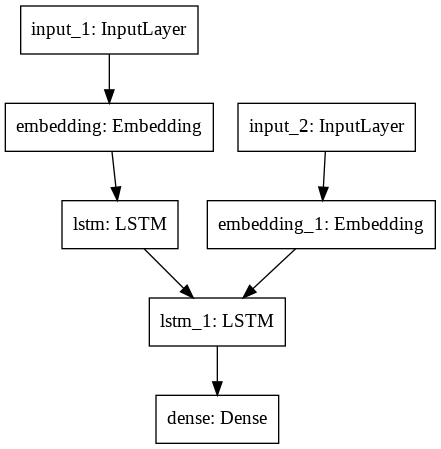

In [ ]:
######################
# make full model
######################
model = Model([encoderInputs,decoderInputs],output)
model.compile(optimizer = RMSprop(), loss = 'categorical_crossentropy')

print(model.summary())
plot_model(model, to_file='model.png')


In [ ]:
######################
# create list with our dictionary words 
######################
dict_list = []
for j in range(max_count_words):
  dict_list.append(vocabularyItems[0:max_count_words][j][0])
print(dict_list[-5:], len(dict_list))

['смеялась', 'другая', 'вытирала', 'канцлер', 'предлагаю'] 7000


In [ ]:
str1 = 'где шашлычек мой дорогой вафел'

In [ ]:
######################
# create func of changing string
######################
def changeUknown(inputString):
  new_str = ''                                          # create new empty string
  str_split = inputString.split()                       # list with words of string
  for word in str_split:
    if word not in dict_list:
      new_str += 'unknown '
    else:
      new_str += (word + ' ')
  return new_str

In [ ]:
changeUknown(str1)            # testing

'где unknown мой дорогой unknown '

In [ ]:
######################
# load weights in model from drive
######################
model.load_weights('/content/drive/MyDrive/Модели/23_Light/Gen_text_100.h5')

In [ ]:

encModel , decModel = makeInferenceModels() # запускаем функцию для построения модели кодера и декодера

for _ in range(7): # задаем количество вопросов, и на каждой итерации в этом диапазоне:
  # Получаем значения состояний, которые определит кодер в соответствии с заданным вопросом

  inputString = input( 'Задайте вопрос : ' )            # write question

  new_str = changeUknown(inputString)                   # change words

  statesValues = encModel.predict(strToTokens(new_str)) # continue the algorithm
  # Создаём пустой массив размером (1, 1)
  emptyTargetSeq = np.zeros((1, 1))    
  emptyTargetSeq[0, 0] = tokenizer.word_index['start'] # положим в пустую последовательность начальное слово 'start' в виде индекса

  stopCondition = False # зададим условие, при срабатывании которого, прекратится генерация очередного слова
  decodedTranslation = '' # здесь будет собираться генерируемый ответ
  while not stopCondition : # пока не сработало стоп-условие
    # В модель декодера подадим пустую последовательность со словом 'start' и состояния предсказанные кодером по заданному вопросу.
    # декодер заменит слово 'start' предсказанным сгенерированным словом и обновит состояния
    decOutputs , h , c = decModel.predict([emptyTargetSeq] + statesValues)
    
    #argmax пробежит по вектору decOutputs'а[0,0,15104], найдет макс.значение, и вернёт нам номер индекса под которым оно лежит в массиве
    sampledWordIndex = np.argmax( decOutputs[0, 0, :]) # argmax возьмем от оси, в которой 15104 элементов. Получили индекс предсказанного слова.
    sampledWord = None # создаем переменную, в которую положим слово, преобразованное на естественный язык
    for word , index in tokenizer.word_index.items():
      if sampledWordIndex == index: # если индекс выбранного слова соответствует какому-то индексу из словаря
        decodedTranslation += ' {}'.format(word) # слово, идущее под этим индексом в словаре, добавляется в итоговый ответ 
        sampledWord = word # выбранное слово фиксируем в переменную sampledWord
    
    # Если выбранным словом оказывается 'end' либо если сгенерированный ответ превышает заданную максимальную длину ответа
    if sampledWord == 'end' or len(decodedTranslation.split()) > maxLenAnswers:
      stopCondition = True # то срабатывает стоп-условие и прекращаем генерацию


    emptyTargetSeq[0, 0] = sampledWordIndex # заносим туда индекс выбранного слова
    statesValues = [h, c] # и состояния, обновленные декодером
    # и продолжаем цикл с обновленными параметрами
  
  print(decodedTranslation[:-3]) # выводим ответ сгенерированный декодером

Задайте вопрос : где шашлычек мой дорогой вафел
 он только не в unknown 
Задайте вопрос : стрельну сигаретку?
 а это 
Задайте вопрос : четкий пацанчик
 а это 
Задайте вопрос : куда пойдем тусить ?
 unknown то unknown 
Задайте вопрос : а ты молодец
 это я его unknown 
Задайте вопрос : сколько лет отсидел ?
 четыре unknown unknown 
Задайте вопрос : как жизнь вообще ?
 а может и у тебя не unknown 
